# LSTM autoencoder를 이용한 시계열 data 이상 감지

시계열 자료의 이상치 검출

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector
import pandas as pd
from matplotlib import pyplot as plt

## Load the data

비정상적인 동작 기간이 labeling 된  인공 시계열 데이터
[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) 를 사용합니다. 데이터는 정열되고 타임스탬프가 지정된 단일 값 메트릭입니다.

학습에는 noise가 포함된 정상 시계열 데이터인인 `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 이상치가 포함된 `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# Train set에 사용할 파일의 URL 경로 설정
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix

# parse_dates=True는 날짜를 pandas datetime 형태로 파싱하라는 의미
# index_col="timestamp"는 timestamp 열을 데이터프레임의 인덱스로 사용하라는 의미
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

# Test set에 사용할 파일의 URL 경로 설정
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix

df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

# 각 데이터프레임의 크기를 출력
print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [3]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## data 시각화
### 정상 시계열 데이터

- 정상 데이터를 autoencoder 훈련에 사용합니다.

<Axes: xlabel='timestamp'>

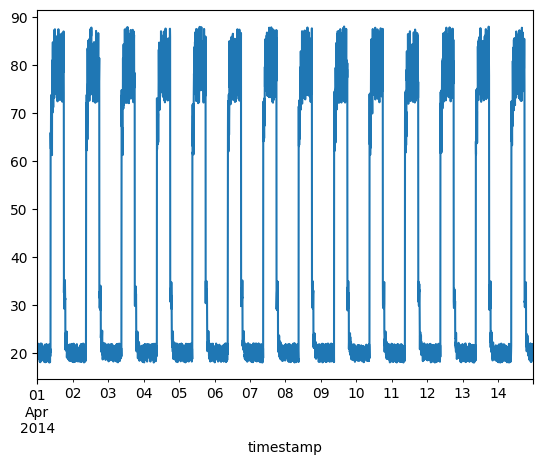

In [5]:
df_small_noise.plot(legend=False)

### 이상이 있는 시계열 데이터

정상 데이터로 훈련된 autoencoder 모델의 테스트를 위해 다음 데이터를 사용하고, 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

<Axes: xlabel='timestamp'>

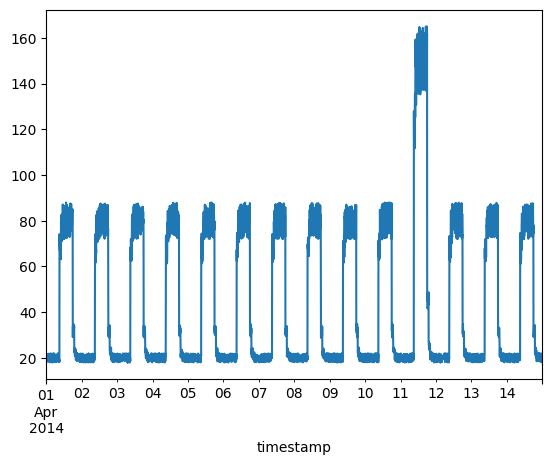

In [6]:
df_daily_jumpsup.plot(legend=False)

## 훈련 데이터 준비

훈련 시계열 데이터 파일(`df_small_noise`)에서 데이터 값을 가져오고 `value` 데이터를 정규화 합니다. 14일 동안 5분마다 `value`가 있습니다.

-   24시간 * 60분 / 5분 = **288 timesteps per day**
-   288 timesteps per day * 14일 = **total 4032 data points**

In [7]:
# 테스트 데이터를 정규화하기 위해 평균과 표준 편차를 정규화하고 저장합니다.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
# standard scaling
df_training_value = (df_small_noise - training_mean) / training_std

print("훈련 샘플 수:", len(df_training_value))

훈련 샘플 수: 4032


In [8]:
# normalize된 df_small_noise
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


### 시퀀스 data 생성

훈련 데이터에서 `TIME_STEPS` 연속 데이터 값을 조합하여 시퀀스를 생성합니다.

In [9]:
# 우리가 사용할 시간 단계를 정의합니다.
TIME_STEPS = 288

# 주어진 값을 받아서 일련의 시퀀스를 생성합니다.
# 각 시퀀스는 주어진 시간 단계만큼의 길이를 가집니다.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []  # 시퀀스를 저장할 리스트 초기화

    # values 리스트를 순회하면서 시퀀스를 생성
    # 각 시퀀스는 i부터 (i + time_steps)까지의 값을 가집니다.
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])

    # 생성된 시퀀스들을 numpy 배열로 변환하여 반환
    return np.stack(output)

# 훈련 데이터를 이용해서 시퀀스를 생성
X_train = create_sequences(df_training_value.values)

print("Training input shape: ", X_train.shape)

Training input shape:  (3745, 288, 1)


## LSTM Autoencoder model


<img src="https://www.researchgate.net/profile/Hoang_Duy_Trinh2/publication/336594630/figure/fig2/AS:814792885420033@1571273170513/LSTM-Autoencoder-for-Anomaly-Detection.png" width=400 />

- RepeatVector 이해  

<img src="https://i.stack.imgur.com/LNXjF.jpg" width=400 />

In [11]:
model = Sequential()

model.add(LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
# RepeatVector 레이어를 추가합니다. 이 레이어는 LSTM 레이어의 출력을 반복하여
# 다음 LSTM 레이어에 같은 출력을 여러 번 제공합니다.
model.add(RepeatVector(X_train.shape[1]))
model.add(Dropout(0.2))
# 두 번째 LSTM 레이어는 출력 시퀀스를 반환합니다.
model.add(LSTM(32, return_sequences=True))
# 출력 레이어로 각 입력 시퀀스에 대한 예측 결과를 생성
model.add(Dense(X_train.shape[2]))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4352      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 repeat_vector_1 (RepeatVect  (None, 288, 32)          0         
 or)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 288, 32)           0         
                                                                 
 lstm_3 (LSTM)               (None, 288, 32)           8320      
                                                                 
 dense_1 (Dense)             (None, 288, 1)            33        
                                                      

## 모델 train

- 재구성 모델이기 때문에 Input과 Target 모두 `X_train`을 사용합니다.  

-  patience는 성능 개선이 없는 에포크를 허용하는 횟수입니다. 여기서는 10회를 설정했습니다.

- mode='min'은 monitor로 지정된 지표가 감소될 때까지 훈련을 계속하라는 의미입니다. 다시 말해, 검증 손실(val_loss)이 줄어들지 않고 특정 에포크(patience 매개변수에서 지정한 수) 동안 그대로일 경우 훈련을 중지하게 됩니다.

In [12]:
history = model.fit(
    X_train, X_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,  # 전체 훈련 데이터의 10%를 검증 데이터로 사용
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ]
)

Epoch 1/100
27/27 [==============================] - 11s 71ms/step - loss: 0.9957 - val_loss: 0.9963
Epoch 2/100
27/27 [==============================] - 1s 25ms/step - loss: 0.9594 - val_loss: 0.9575
Epoch 3/100
27/27 [==============================] - 1s 26ms/step - loss: 0.9197 - val_loss: 0.9298
Epoch 4/100
27/27 [==============================] - 1s 25ms/step - loss: 0.9072 - val_loss: 0.9196
Epoch 5/100
27/27 [==============================] - 1s 19ms/step - loss: 0.8842 - val_loss: 0.8752
Epoch 6/100
27/27 [==============================] - 1s 19ms/step - loss: 0.8719 - val_loss: 0.8645
Epoch 7/100
27/27 [==============================] - 0s 18ms/step - loss: 0.8865 - val_loss: 0.8798
Epoch 8/100
27/27 [==============================] - 1s 19ms/step - loss: 0.8571 - val_loss: 0.8058
Epoch 9/100
27/27 [==============================] - 0s 18ms/step - loss: 0.8288 - val_loss: 0.8306
Epoch 10/100
27/27 [==============================] - 1s 21ms/step - loss: 0.7859 - val_loss: 0.686

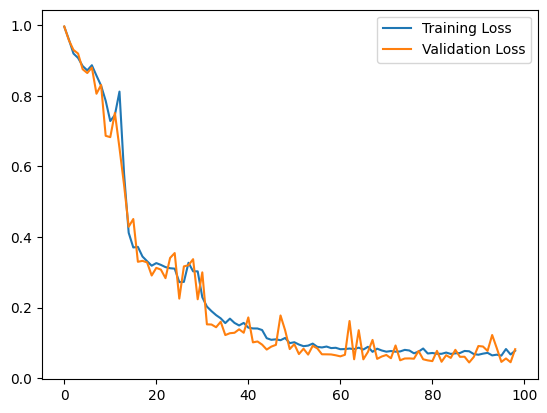

In [13]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 감지

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1.   훈련 샘플에서 MAE 손실을 찾습니다.
2.   최대 MAE 손실 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 이를 이상 감지의 `threshold`로 설정합니다.
3.   샘플의 재구성 손실이 이 `threshold` 보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 `anomaly`로 분류할 것입니다.

- MAE 손실 시각화

118/118 [==============================] - 2s 8ms/step


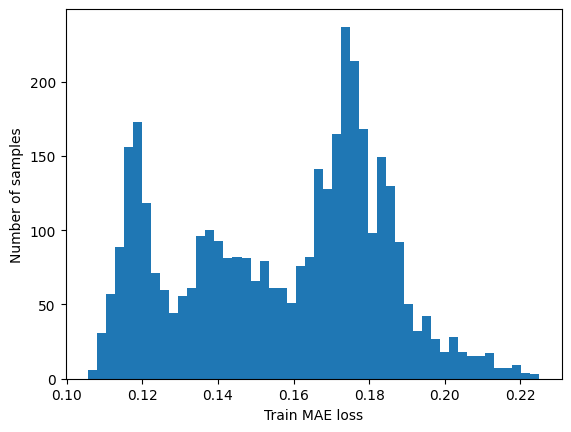

In [14]:
X_train_pred = model.predict(X_train)

# 예측값과 실제 값 간의 차이를 절대값으로 계산한 후, 이를 평균내어 각 샘플에 대한 MAE를 계산합니다.
# 이 값이 크면 클수록 모델이 실제 데이터를 잘 예측하지 못하고 있다는 의미입니다.
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# 히스토그램은 모델의 예측 오차가 어떻게 분포되어 있는지를 보여줍니다.
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

- train set의 최대 MAE 손실을 재구성 손실 임계값으로 정합니다.

In [15]:
threshold = np.max(train_mae_loss)
print("재구성 오류 임계값: ", threshold)

재구성 오류 임계값:  0.22492686823815225


### 재구성 비교

우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 봅니다.
이것은 훈련 데이터 세트 1일차의 288개 timestep 입니다.

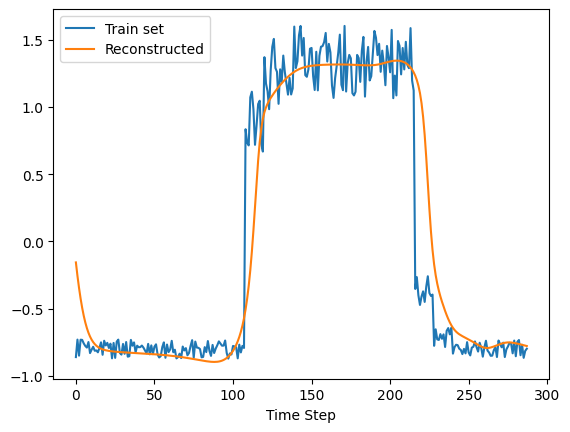

In [16]:
# 원래 데이터
plt.plot(X_train[0], label='Train set')
# 모델에 의한 예측값
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel("Time Step")
plt.legend()

### 테스트 데이터 준비
- Test set을 standard scale   
- 분포가 바뀌면 안되므로 Train set 에서 구해 놓았던 평균과 표준 편차를 그대로 사용
- 시각화

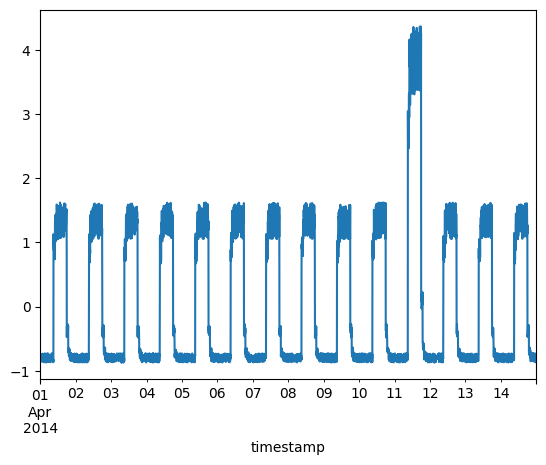

In [17]:
#df_daily_jumpsup'의 모든 값에서 훈련 데이터셋의 평균값 'training_mean'을 뺀 다음,
#훈련 데이터셋의 표준 편차 'training_std'로 나누어 테스트 데이터셋을 표준화 후 시각화
df_test_value = (df_daily_jumpsup - training_mean) / training_std

fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

- Test set에서 시퀀스 data 생성

In [18]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


- test set의 MAE loss 구하기

In [19]:
x_test_pred = model.predict(x_test)
#각 샘플에 대한 평균 절대 오차를 계산합니다.
#이를 모든 특성에 대해 평균 내어 샘플 당 하나의 스칼라 값으로 표현합니다.
#'axis=1'은 오차를 특성 축을 따라 평균 내라는 것을 지정
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))
test_mae_loss.shape

118/118 [==============================] - 1s 9ms/step


(3745,)

- MAE 손실 시각화

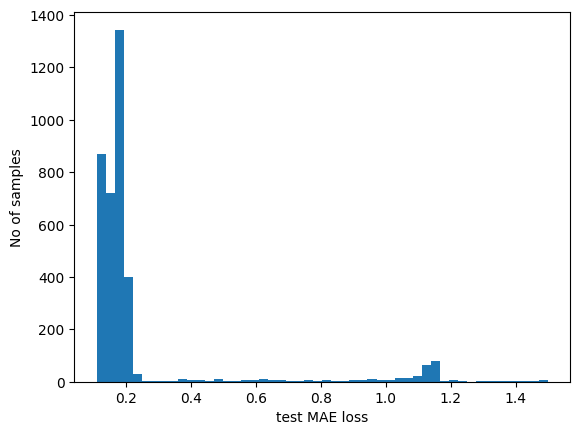

In [20]:
plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

- 모든 이상 샘플 감지

In [21]:
threshold

0.22492686823815225

In [22]:
# test_mae_loss의 각 요소가 임계값보다 큰지 확인합니다.
# 값이 임계값보다 크면 True, 아니면 False
anomalies = test_mae_loss > threshold
anomalies

array([False, False, False, ..., False, False, False])

In [23]:
print("이상 감지된 샘플 수: ", np.sum(anomalies))
print("이상 감지된 샘플의 인덱스: ", np.where(anomalies))

이상 감지된 샘플 수:  403
이상 감지된 샘플의 인덱스:  (array([ 372,  373,  374,  375,  376,  377,  378,  379,  380,  387,  391,
        392,  394,  395,  396, 2106, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 28

## 이상치 plot

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 `timestamps`를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `X_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 마지막 time_steps-1 데이터 값을 제외한 모든 값은 `time_steps` 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상이라는 것을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.  

그러므로 `TIME_STEPS`기간 전체 샘플 `[(i - timesteps + 1) ~ (i)]`이 비정상인 경우 데이터 `i`는 비정상으로 분류할 수 있습니다.

In [26]:
anomalous_data_indices = []  #이상치의 인덱스를 저장할 빈 리스트 생성

#데이터 내의 각 데이터 포인트를 반복하면서 이상치를 찾습니다.
#인덱스는 시계열 데이터에서 설정한 TIME_STEPS 크기의 슬라이딩 윈도우를 고려하여 선택
#해당 윈도우 내의 모든 데이터 포인트가 이상치라면
#해당 윈도우의 마지막 데이터 포인트의 인덱스를 anomalous_data_indices 리스트에 추가
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

원본 테스트 데이터 플롯에 모델이 탐지한 이상치를 오버레이해 시각화

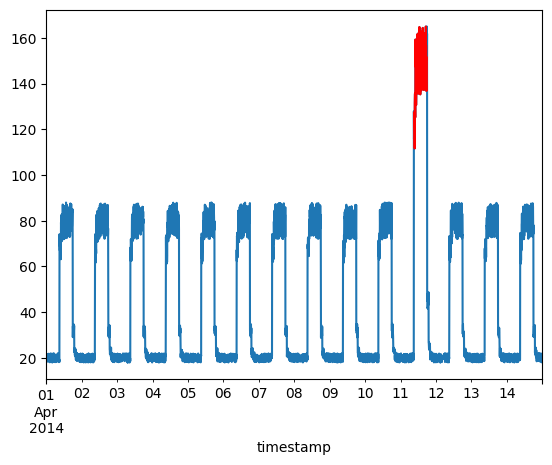

In [27]:
#리스트에 저장된 이상치가 발견된 시점의 인덱스를 사용하여
#df_daily_jumpsup 데이터프레임에서 해당 시점의 데이터를 추출
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()